Notion連結: https://www.notion.so/TRADINGBOT-ede09f79ef7749cfb07e776bae0bd1f7?pvs=4

操作股票的方法有許多種，網路上的資源也是無窮無盡，想要徹底研究透徹需要花上非常大量的時間。與其花上大量時間鑽研方法，不如盡快決定操作方法賺取實戰經驗，且在這端時間也可能錯過良好的投資機會。因此我按決定以下三個步驟建立我的投資系統，進行回測後投入實際市場已取得實績來驗證自己的方法是否能得到預期成效。

In [3]:
import os
import time
import talib
import traceback
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import pandas_datareader.data as web
from matplotlib import pyplot as plt


In [4]:
# 顯示繁體中文
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei')

In [5]:
url = './data/stock_list.csv'
stockdata_url = './data/stocks_info/'

將變動頻率較少的重要資訊儲存下來以便做比較，以下介紹這些欄位資訊


**公司營收(`totalRevenue`)**:
營收是指公司在一定時期內（通常為一個季度或一年）通過其主營業務所產生的收入。營收是衡量公司規模和經營成果的重要指標，反映了市場需求、產品競爭力等方面的信息。公司營收與成長方式是基本面選股必看指標。

**毛利率(`grossMargins`)**:
毛利率是指營業毛利與營業收入之間的比率。營業毛利等於營業收入減去營業成本。毛利率反映了公司的產品價格與成本之間的關係，可以衡量公司的盈利能力和競爭優勢。

**營益率(`operatingMargins`)**:
營益率是指營業利潤與營業收入之間的比率。營業利潤等於營業收入減去營業成本和營業費用。營益率反映了公司在扣除營業成本和費用後的盈利能力，衡量公司經營效率和競爭力。

**淨利率(`profitMargins`)**:
淨利率是指淨利潤與營業收入之間的比率。淨利潤等於營業收入減去營業成本、費用及稅收等各項支出。淨利率反映了公司在扣除所有成本和支出後的盈利能力，衡量公司整體經營績效。

**每股盈餘(Earning per share,`trailingEps`)**:
每股盈餘是指公司淨利潤除以普通股股數，表示每股股票所分配到的淨利潤。EPS 是衡量公司盈利能力和股票價值的重要指標。另外，`forwardEps`是預期盈餘(forward EPS)。

**本益比(Price-to-Earning Ratio,P/E,`PE`)**: 
本益比是指股票價格與每股盈餘之間的比率。本益比用於評估股票價格是否合理，並與同行業其他公司以及行業平均水平進行比較。一般來說，本益比較低的股票可能意味著其價格相對於盈利水平較為合理，具有投資價值。公式: $(每股價格/每股盈餘)\times 100\%$

**股息發放率(Payout Ratio,`payoutRatio`)**:
股息發放率 (Payout Ratio)： 股息發放率是一家公司發放股息相對於其總淨利潤的比例。這個比例可以讓投資者了解公司將其盈利的多少比例返還給股東，而將多少比例留在公司內部用於再投資或償還債務。股息發放率的計算公式為：$股息發放率 = (每股股息 / 每股盈餘)\times 100\%$

股息發放率的意義在於，它可以幫助投資者理解公司的盈餘分配策略。一個高的股息發放率可能意味著公司分配給股東的利潤比例較高，這可能對尋找穩定收入的投資者有吸引力。然而，過高的股息發放率也可能表示公司沒有足夠的盈餘用於再投資或償還債務。反之，一個低的股息發放率可能意味著公司正在將更多的盈餘留在公司內部，用於業務擴張或債務償還。

**每股淨資產(Book Value,`bookValuePerShare`)**:
每股淨資產是一家公司的資產減去負債後，再除以公司的流通在外的股份總數。這個指標可以顯示一家公司的內在價值，並可以用來與市價進行比較，以判定股票是否被過度估值或被低估。計算公式如下：$每股淨資產 = (總資產 – 總負債) / 流通在外的股份總數$

**營運現金流(`operatingCashflow`)**:
營運現金流是一家公司營業活動中產生的現金流量，包括賣出商品或提供服務所得的現金，以及支付員工薪水、租金、稅款等營運成本的現金。這個指標可以顯示一家公司的現金收入情況，並可以用來評估一家公司的長期盈利能力。計算公式如下：$營運現金流 = 營業利潤 + 折舊 + 攤銷 + 非現金費用 +/- 營運資本變動$

營運資本變動包括存貨、應收賬款、應付賬款等的變化。這兩個指標都是投資者基本面選股過程評估公司財務狀況和投資風險的重要工具。

**自由現金流(`freeCashflow`)**:
自由現金流是指一家公司營運活動產生的現金流量，扣除資本支出（即投資於固定資產以維持或增加生產能力的支出）後所剩餘的現金。這個指標可以顯示一家公司營運所產生的現金，超過保持現有業務運營所需要的資本投資之後，還能剩下多少現金用於分派給股東、償還債務、收購其他公司或進行新的投資。計算公式如下：$自由現金流 = 營運現金流 – 資本支出$


**總股數皆以 流通在外的股數(outstanding share,`sharesOutstanding`計算)**

In [6]:
basics = ['totalRevenue',
          'grossMargins',
          'operatingMargins',
          'profitMargins',
          'EPS',
          'PE',
          'payoutRatio',
          'bookValuePerShare',
          'operatingCashflow',
         'freeCashflow',
          'sharesOutstanding'
         ]

In [7]:
# 讀取所有票資訊
def get_all_stocks_info(source,saving=False):
    stocks = pd.read_csv(source,index_col=0)
    stocks_dict = {}

    for i in range(len(stocks)):
        s = stocks.iloc[i]
        
        if s['代號'] > 9999:
            continue
        elif 'KY' in s['股票名稱']:
            continue
        symbol = str(s['代號']).zfill(4) if s['代號']< 1000 else str(s['代號'])
        stocks_dict[s['股票名稱']] = yf.Ticker(symbol+'.TW')
        
            
        if saving:
            
            stock_data=None
            info = stocks_dict[s['股票名稱']].info
            
            for r,d,f in os.walk(stockdata_url):
                if f == symbol + '.csv':
                    stock_data = pd.read_csv(stockdata_url+symbol+'.csv')

            revenue = info['totalRevenue'] if 'totalRevenue' in info.keys() else 0
            grossMargins = info['grossMargins'] if 'grossMargins' in info.keys() else 0.0
            operatingMargins = info['operatingMargins'] if 'operatingMargins' in info.keys() else 0.0
            profitMargins = info['profitMargins'] if 'profitMargins' in info.keys() else 0.0
            EPS = info['trailingEps'] if 'trailingEps' in info.keys() else 0.0
            PE = info['currentPrice']/ info['trailingEps']*100 if 'trailingEps' in info.keys() else 0.0
            payoutRatio = info['payoutRatio'] if 'payoutRatio' in info.keys() else 0
            bookValuePerShare = info['bookValue'] / info['sharesOutstanding'] if 'sharesOutstanding' in info.keys() else 0.0
            operatingCashflow = info['operatingCashflow'] if 'operatingCashflow' in info.keys() else 0
            freeCashflow = info['freeCashflow'] if 'freeCashflow' in info.keys() else 0
            sharesOutstanding = info['sharesOutstanding'] if 'sharesOutstanding' in info.keys() else 0
            
            
            if stock_data:
                stock_data.append([[revenue,grossMargins,operatingMargins,profitMargins,EPS,
                                   PE,payoutRatio,bookValuePerShare,operatingCashflow,freeCashflow,sharesOutstanding]])
                
            else:
                stock_data = pd.DataFrame([[revenue,grossMargins,operatingMargins,profitMargins,EPS,
                                   PE,payoutRatio,bookValuePerShare,operatingCashflow,freeCashflow,sharesOutstanding]])
                stock_data.columns = basics
            
            stock_data.to_csv(stockdata_url+symbol+'.csv')
         
        
        
            if i%10 == 0:
                time.sleep(1.5)
    
    return stocks_dict

In [8]:
stock_list = get_all_stocks_info(url,saving=False)

In [ ]:
info = stock_list['台積電'].info
yf.pdr_override()
raw = web.get_data_yahoo(['2330.TW'])
data = pd.DataFrame(raw['Close'])
# 對數報酬率
data['r'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)
# 策略報酬率
data['s'] = data['Close'].rolling(window).mean()
# 動量
data['m'] = data['r'].rolling(window).mean()
# 波動率
data['v'] = data['r'].rolling(window).std()
data.dropna(inplace=True)

# 本益比計算
data['PE'] = data['Close'].apply(lambda x: x/info['trailingEps'] if info['trailingEps']!=0 else x)
data['2000-02-01':'2000-12-31'].mean()

# I. 利用基本面決定標的 

## 本益比

**本益比（ Price to Earning Ratio ，P/E 或 PER ）**，通常是用來判斷股票是便宜或貴的依據，預測買該支股票的回本時間，也是用來評估企業股價與獲利淺力的判斷標準。本益比是指你的投入成本和每年收益間的比例，簡單來講，就是未來的每年要賺 1 元的收益，需要投入幾倍成本、要多久才能回本。公式如下:

$$本益比= 股價/每股盈餘(EPS)$$

例如你去銀行定存，定存利率是 1 ％ ，代表存 100 元本錢，每年發 1 元的利息，100 ÷ 1 = 100 本益比就是 100 倍！也可以說是，如果要賺每年 1 元的收益，要投入 100 元的成本！

### 本益比的背後意思
本益比越低：代表投資者能夠以相對較低價格購入股票，或是能較快回收本金。

本益比越高：代表你目前是以相對較高的價格購入股票，或是要較晚才能收回本金。

### 股票本益比多少才合理？
本益比不是一個固定的倍率，它是市場上對於這個標的的一個估值。如果當今天對於這檔標的越看好，市場就會覺得我投資你晚一點才回收我的本金也沒關係，因此就願意給這檔股票高一點的本益比；換言之，如果市場不看好這檔股票，願意給的本益比就會減少。

### 股票的本益比不該超過 20 倍
合理的本益比，平均大約是 15 倍。以投資台灣 50（ 0050 ）為例，台灣 50 的投資報酬率每年平均大約是 5 ％ ，換句話說，投資 100 元，它每年會賺 5 元的獲利！本益比就是 20 倍！這麼安全的股票，本益比都只有 20 倍，如果你買的股票本益比超過 20 倍，那就太貴了。

我們很難預知未來公司的獲利是多少，所以通常會用過去的每股盈餘來計算本益比，常用的有 2 種：

    1. 去年的每股盈餘推估本益比
    2. 近四季公布的每股盈餘
    
目前看到的本益比，大多都是用過去的每股盈餘算出來的，使用過去的每股盈餘來算本益比必須要注意，如果盈餘正在成長和衰退的公司，本益比就沒辦法評估得很準確，所以在比較 2 間公司的本益比時要注意：

* 本益比越高越好？當本益比很高，不要認為它很貴，要先看看公司是否正在成長
* 本益比越低越好？當本益比很低，也不要覺得它很便宜，先觀察公司是否正在衰退
* 如果公司去年虧錢，沒有獲利，就會算不出本益比，如果公司虧錢，在下面運算時就會得出負數的本益比

因此除了本益比之外，還需要得到營收成長的資料，因此需要使用到 `yf.Ticker.info['revenueGrowth']`


### 實作
為了簡單篩選有價值的公司，以下程式碼計算每間公司的去年本益比、營收成長率來選擇所要分析的股票，包含對數報酬率`r`、策略報酬率`s`、動量`m`、波動率`v`，這些資料除了營收成長率以外，其他都是以去年平均計算。

In [ ]:
yf.pdr_override()
don_raw = web.get_data_yahoo(['4919.TW'])
don_data = pd.DataFrame(don_raw['Close'])

In [ ]:
don_data['r'] = np.log(don_data['Close'] / don_data['Close'].shift(1))
don_data.dropna(inplace=True)
# 策略報酬率
don_data['s'] = don_data['Close'].rolling(window).mean()
# 動量
don_data['m'] = don_data['r'].rolling(window).mean()
# 波動率
don_data['v'] = don_data['r'].rolling(window).std()
don_data['2022-01-01':'2022-12-31']['v'].mean()

In [ ]:
d

In [9]:
comp_health = pd.DataFrame()
index = 0 
window = 20
stock_csv_url= './data/stocks/'
year = '2022'

In [ ]:
# PE = info['currentPrice']/ info['trailingEps']
# if 沒有股票的檔案
for i,k in stock_list.items():
    i = ''.join(k if k!='*' else '' for k in i)
    info = None
    
    try:
        info = k.info
    except:
        print(f'{k} cannot get info')
        index+=1
        continue
    
    if info:
        start = year + '-01-01'
        end = year + '-12-31'
        
        symbol = info['symbol']
        growth = info['revenueGrowth'] if 'revenueGrowth' in info.keys() else 0
        operatingCashflow = info['operatingCashflow'] if 'operatingCashflow' in info.keys() else 0
        freeCashflow = info['freeCashflow'] if 'freeCashflow' in info.keys() else 0
        price = info['currentPrice'] if 'currentPrice' in info.keys() else 0
        value = info['sharesOutstanding']* price if 'sharesOutstanding' in info.keys() else 0
        
        yf.pdr_override()
        raw = web.get_data_yahoo([symbol])
        data = pd.DataFrame(raw['Close'])
        # 對數報酬率
        data['r'] = np.log(data['Close'] / data['Close'].shift(1))
        data.dropna(inplace=True)
        # 策略報酬率
        data['s'] = data['Close'].rolling(window).mean()
        # 動量
        data['m'] = data['r'].rolling(window).mean()
        # 波動率
        data['v'] = data['r'].rolling(window).std()
        data.dropna(inplace=True)
        
        if 'currentPrice' not in info.keys():
            print(f"{i}({info['symbol']}) does not have currentPrice")
        elif 'trailingEps' not in info.keys():
            print(f"{i}({info['symbol']}) does not have trailingEps")
        else:
            # 本益比計算
            data['PE'] = data['Close'].apply(lambda x: x/info['trailingEps'] if info['trailingEps']!=0 else x)
        
        if 'PE' in data.columns and len(data['PE']) > 0:
            # 儲存csv
            _m = data.mean()
            comp_health = comp_health.append([[i,symbol,price,_m['r'],_m['s'],_m['m'],_m['v'],_m['PE'],
                                               growth,operatingCashflow,freeCashflow,value]])
            
            
            print(f"{i}({info['symbol']}) Done.")
    index+=1
    if index % 10 == 0:
        time.sleep(5)

comp_health.columns = ['name','symbol','currentPrice','r','s','m','v',
                    'PE','revenueGrowth','operatingCashflow','freeCashflow','marketValue']
comp_health.to_csv(f"{stock_csv_url}market-{year}.csv")

In [10]:
# 讀取狀態檔案
comp_health = pd.read_csv(stock_csv_url+f'market-{year}.csv',index_col=0)

In [11]:
comp_health

,name,symbol,currentPrice,r,s,m,v,PE,revenueGrowth,operatingCashflow,freeCashflow,marketValue
0,台泥,1101.TW,31.75,0.000102,24.159777,0.000120,0.019365,20.154801,0.099,18139961344,-9740116992,2.265737e+11
0,亞泥,1102.TW,39.20,0.000209,27.928087,0.000207,0.018754,7.813873,-0.137,4972635136,2690240512,1.390252e+11
0,嘉泥,1103.TW,18.10,0.000111,13.715810,0.000124,0.017814,29.213929,0.409,-321508000,-348988128,1.192598e+10
0,環泥,1104.TW,25.50,0.000302,14.422852,0.000315,0.017524,5.691985,0.098,1358996992,477275360,1.716703e+10
0,幸福,1108.TW,13.80,0.000047,8.483068,0.000060,0.018514,5.053058,0.319,599665024,-78199248,5.585384e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
0,元大上證50,6206.TW,65.00,0.000298,65.300651,0.000303,0.017377,15.424953,-0.440,1451561984,1486098816,9.299030e+09
0,美德醫療-DR,9103.TW,5.95,0.000089,5.798516,0.000094,0.026370,-3.278514,-0.160,2778000,-9995500,3.242220e+09
0,泰金寶-DR,9105.TW,3.21,-0.000384,5.073256,-0.000385,0.021775,29.628363,-0.006,11647238144,4239069440,1.984294e+10
0,越南控-DR,9110.TW,7.15,-0.000175,5.371464,-0.000186,0.019630,59.485153,-0.052,-4360069,-6853905,6.489912e+09


In [12]:
# 查看0050的波動作為波動參考基準
yf.pdr_override()
raw = web.get_data_yahoo(['0050.TW'])
standard = pd.DataFrame(raw['Close'])
standard

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2008-01-02,60.009998
2008-01-03,58.889999
2008-01-04,59.009998
2008-01-07,56.389999
2008-01-08,56.980000
...,...
2023-10-24,123.949997
2023-10-25,124.199997
2023-10-26,121.750000


In [13]:
standard['r'] = np.log(standard['Close'] / standard['Close'].shift(1))
standard['v'] = standard['r'].rolling(window).std()
standard.dropna(inplace=True)
standard = standard[year+'-01-01':year+'-12-31']
standard

,Close,r,v
Date,,,
2022-01-03,146.399994,0.006166,0.005768
2022-01-04,149.600006,0.021623,0.007193
2022-01-05,149.300003,-0.002007,0.007273
2022-01-06,147.899994,-0.009421,0.007740
2022-01-07,146.600006,-0.008828,0.008054
...,...,...,...
2022-12-26,111.099998,0.003607,0.012013
2022-12-27,111.599998,0.004490,0.011841
2022-12-28,110.000000,-0.014441,0.011929


In [14]:
standard['v'].mean()

0.013575593599436057

In [15]:
standard['v'].max()

0.019785857306590465

In [16]:
standard['v'].min()

0.005768191295204854

In [17]:
len(comp_health)

898

In [18]:
comp_health.loc[comp_health['symbol']=='2330.TW']

,name,symbol,currentPrice,r,s,m,v,PE,revenueGrowth,operatingCashflow,freeCashflow,marketValue
0,台積電,2330.TW,546.0,0.000326,161.216655,0.000337,0.018142,4.456826,-0.1,1452072763392,13664679936,1.415893e+13


### 波動率
以元大50這隻前50大企業組成的股票作為大盤分析波動率，可以看到其波動率在2022年平均落在0.013，最大值為0.019，最小為0.005，而指數占比大的台積電的平均波動為0.018，可以假設以0.019為標準，以上為波動率相對大的股票，其風險較高，適合短期操作甚至開槓桿;0.019以下、0.005以上為相對穩定的股票，適合長期投資，降低積極投資的風險。

### 本益比&營收成長
本益比則以台積電為參考，本益比0-10且營收成長-0.2以上的為有價值的股票，本益比10以上的則為無法長期持有的標的，換句話說，可以假設本益比10以上的為風險較大的股票，若營收成長率高，則表示該股票正在成長當中。



假設投資組合的商品數為$N$，那麼以現在年紀來說，應投資$\frac{2}{3} N$高風險股票，$\frac{1}{3}N$穩定股

In [19]:
# 風險股
# 波動率大於 0.018，略大於市場
v_stocks=comp_health.loc[comp_health['v']>0.018]
# 本益比介於0~10之間，可以相對便宜的價格購買且可較快回收本金
v_stocks = v_stocks.loc[(v_stocks['PE']<10)&(v_stocks['PE']>0)]
# 營收成長大於-0.2
v_stocks = v_stocks.loc[v_stocks['revenueGrowth']>-0.2]
# 營運現金流大於0
v_stocks = v_stocks.loc[v_stocks['operatingCashflow']>0]
# 對數報酬率大於0
v_stocks = v_stocks.loc[v_stocks['r']>0]
# 自由現金流大於0
v_stocks = v_stocks.loc[v_stocks['freeCashflow']>=0]
# 依照市值大小順序排列
v_stocks= v_stocks.sort_values('marketValue',ascending=False)
v_stocks

,name,symbol,currentPrice,r,s,m,v,PE,revenueGrowth,operatingCashflow,freeCashflow,marketValue
0,台積電,2330.TW,546.00,0.000326,161.216655,3.367516e-04,0.018142,4.456826,-0.100,1452072763392,13664679936,1.415893e+13
0,鴻海,2317.TW,103.50,0.000635,59.415352,6.421622e-04,0.021967,6.705373,-0.136,297906831360,145056628736,1.434665e+12
0,台達電,2308.TW,315.50,0.000262,122.441479,2.731131e-04,0.022414,9.414774,0.117,59564933120,27674148864,8.195239e+11
0,廣達,2382.TW,208.00,0.000174,62.223700,1.981096e-04,0.020075,6.980928,-0.094,99764379648,47639797760,8.017402e+11
0,研華,2395.TW,335.00,0.000363,119.419669,3.582148e-04,0.019539,8.934948,0.012,9996003328,12680451072,2.868404e+11
...,...,...,...,...,...,...,...,...,...,...,...,...
0,全台,3038.TW,28.25,0.000221,13.234183,2.561257e-04,0.024522,4.499562,0.007,933550016,632926144,4.198346e+09
0,欣巴巴,9906.TW,50.20,0.000083,16.310095,1.279194e-04,0.036478,2.790099,1.015,2007947008,2244153344,4.183869e+09
0,連宇,2482.TW,40.00,0.000085,18.291279,1.211210e-04,0.025004,4.759718,0.265,397932000,369690880,3.114040e+09
0,華園,2702.TW,19.25,0.000145,10.561368,1.855538e-04,0.022018,5.038983,0.018,152120992,171073504,3.014820e+09


In [20]:
# 穩定股
# 波動率落在0.006~0.018之間
s_stocks=comp_health.loc[(comp_health['v']>=0.006)&(comp_health['v']<0.018)]
# 本益比落在10~20之間
s_stocks = s_stocks.loc[(s_stocks['PE']>=10)&(s_stocks['PE']<=20)]
# 營收成長大於-0.1
s_stocks = s_stocks.loc[s_stocks['revenueGrowth']>-0.1]
# 營運現金流大於0
s_stocks = s_stocks.loc[s_stocks['operatingCashflow']>0]
# 自由現金流大於0
s_stocks = s_stocks.loc[s_stocks['freeCashflow']>=0]
# 對數報酬率大於0
s_stocks = s_stocks.loc[s_stocks['r']>0]
# 依照市值大小順序排列
s_stocks = s_stocks.sort_values('marketValue',ascending=False)
s_stocks

,name,symbol,currentPrice,r,s,m,v,PE,revenueGrowth,operatingCashflow,freeCashflow,marketValue
0,中華電,2412.TW,116.00,0.000034,89.261853,0.000030,0.010803,18.641185,0.020,77009240064,36689162240,8.998642e+11
0,兆豐金,2886.TW,38.15,0.000171,21.489259,0.000180,0.015982,10.400439,0.224,31524931584,0,5.360571e+11
0,統一,1216.TW,68.80,0.000281,38.156186,0.000285,0.017498,11.315821,0.053,62360616960,43781353472,3.909230e+11
0,統一超,2912.TW,259.50,0.000271,157.599624,0.000264,0.016223,16.400494,0.091,33445931008,15380841472,2.697814e+11
0,遠傳,4904.TW,74.60,0.000101,61.017272,0.000089,0.011328,19.025004,0.047,27143940096,17812033536,2.430841e+11
0,台灣高鐵,2633.TW,30.00,0.000096,19.344517,0.000100,0.009601,16.275426,0.847,25242077184,15159008256,1.688487e+11
0,中保科,9917.TW,114.50,0.000181,63.287298,0.000168,0.012561,10.894089,0.126,3176570880,1637264256,5.068995e+10
0,大統益,1232.TW,140.50,0.000427,61.351128,0.000436,0.011650,10.092002,-0.046,1755474048,1313577472,2.247649e+10
0,全國,9937.TW,67.60,0.000172,32.758546,0.000238,0.013566,13.854645,0.043,1385686016,727213888,2.089131e+10
0,華票,2820.TW,14.45,0.000008,12.053483,0.000027,0.012374,13.395541,0.476,3388179968,0,1.940577e+10


In [21]:
len(v_stocks)

90

In [22]:
len(s_stocks)

32

In [23]:
# 經過排序取 穩定前2, 風險前4作為組合
s_stocks[:2]

,name,symbol,currentPrice,r,s,m,v,PE,revenueGrowth,operatingCashflow,freeCashflow,marketValue
0,中華電,2412.TW,116.00,0.000034,89.261853,0.00003,0.010803,18.641185,0.020,77009240064,36689162240,8.998642e+11
0,兆豐金,2886.TW,38.15,0.000171,21.489259,0.00018,0.015982,10.400439,0.224,31524931584,0,5.360571e+11


In [24]:
v_stocks[:4]

,name,symbol,currentPrice,r,s,m,v,PE,revenueGrowth,operatingCashflow,freeCashflow,marketValue
0,台積電,2330.TW,546.0,0.000326,161.216655,0.000337,0.018142,4.456826,-0.100,1452072763392,13664679936,1.415893e+13
0,鴻海,2317.TW,103.5,0.000635,59.415352,0.000642,0.021967,6.705373,-0.136,297906831360,145056628736,1.434665e+12
0,台達電,2308.TW,315.5,0.000262,122.441479,0.000273,0.022414,9.414774,0.117,59564933120,27674148864,8.195239e+11
0,廣達,2382.TW,208.0,0.000174,62.223700,0.000198,0.020075,6.980928,-0.094,99764379648,47639797760,8.017402e+11


In [25]:
# 組成投資組合
comb = (2,4)
comb_list = s_stocks[:comb[0]]['symbol'].to_list() + v_stocks[:comb[1]]['symbol'].to_list()

In [26]:
comb_list

['2412.TW', '2886.TW', '2330.TW', '2317.TW', '2308.TW', '2382.TW']

# II. 技術分析交易策略&法人資料走向

In [27]:
portfolio = dict()

In [28]:
# 開始取得投資組合的歷史資料
for c in comb_list:
    yf.pdr_override()
    raw = web.get_data_yahoo([c])
    portfolio[c] = pd.DataFrame(raw['Close'])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


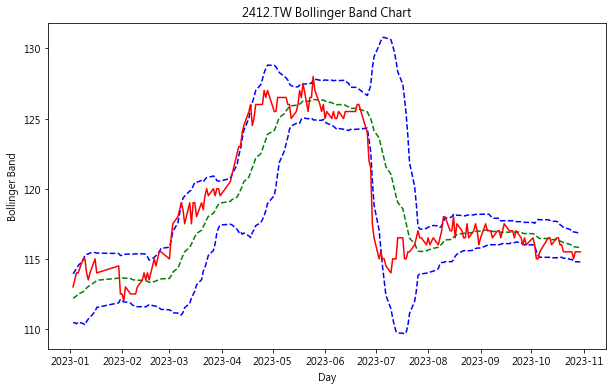

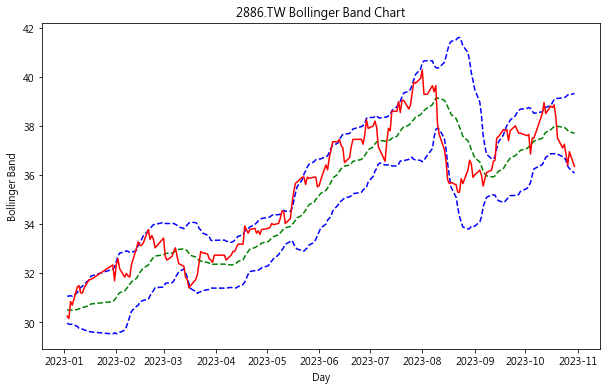

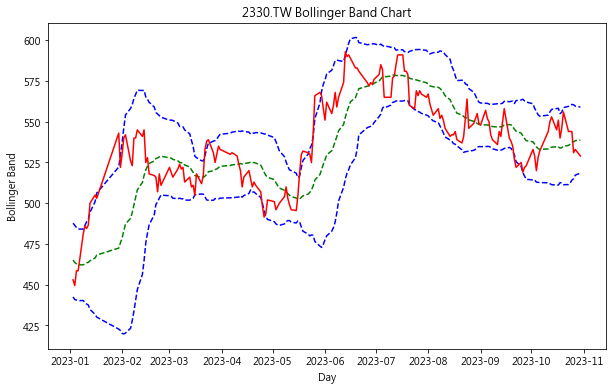

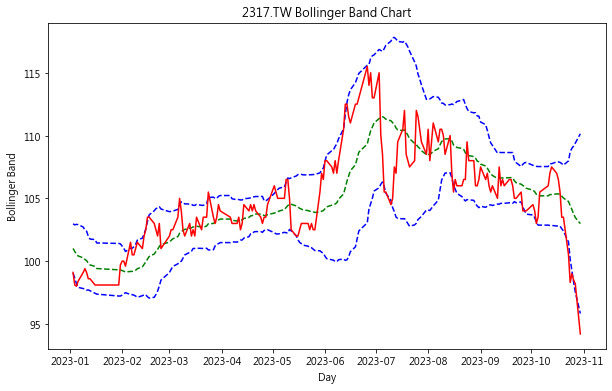

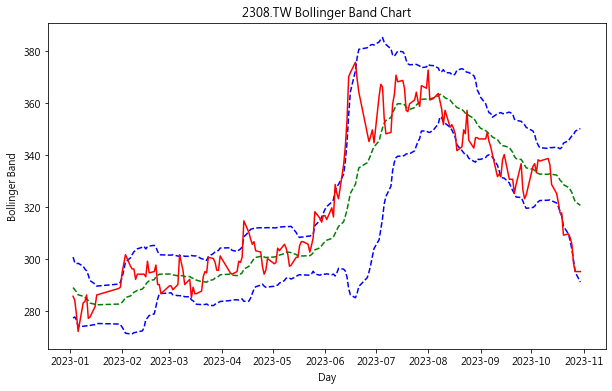

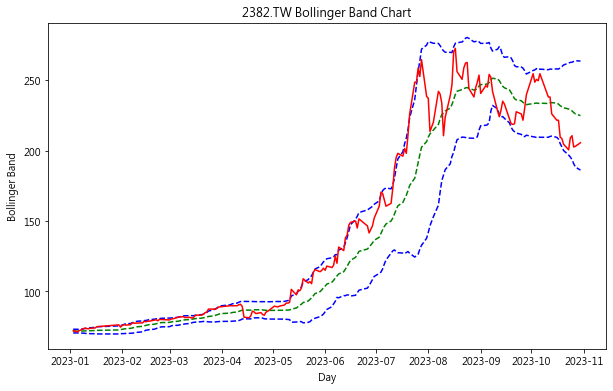

In [41]:
for i,k in portfolio.items():
    upperband,middleband,lowerband = talib.BBANDS(k['Close'],timeperiod=20,nbdevup=2,nbdevdn=2,matype=0)
    
    plt.figure(figsize=(10,6))

    plt.plot(upperband['2023-01-01':'2023-10-30'],
             label="upperband",color='b',
             linestyle='--')
    plt.plot(middleband['2023-01-01':'2023-10-30'],
             label="middleband",color='g',linestyle='--')
    plt.plot(lowerband['2023-01-01':'2023-10-30'],
             label="lowerband",color='b',
             linestyle='--')
    plt.plot(k['2023-01-01':'2023-10-30']['Close'],
             label='close',color='r',
             linestyle='solid',)
    plt.title(f"{i} Bollinger Band Chart") 
    plt.xlabel("Day") 
    plt.ylabel("Bollinger Band")
    

In [ ]:
# 目前除了台積電還維持在中軌與上軌之間，其他都是向下的趨勢，主要都是接近下軌，可以等反彈。

In [47]:
a = portfolio['2330.TW']
au,am,al = talib.BBANDS(a['Close'],timeperiod=20,nbdevup=2,nbdevdn=2,matype=0)
# a['Close'].shift(1)> 
a['cross_lower'] = np.where((a['Close']>al) & (a['Close'].shift(1)<al),1,0)
a['cross_lower'].tail(40)

Date
2023-08-31    0
2023-09-01    0
2023-09-04    0
2023-09-05    0
2023-09-06    0
2023-09-07    0
2023-09-08    0
2023-09-11    0
2023-09-12    0
2023-09-13    0
2023-09-14    0
2023-09-15    0
2023-09-18    0
2023-09-19    0
2023-09-20    0
2023-09-21    0
2023-09-22    0
2023-09-25    1
2023-09-26    0
2023-09-27    0
2023-09-28    0
2023-10-02    0
2023-10-03    0
2023-10-04    0
2023-10-05    0
2023-10-06    0
2023-10-11    0
2023-10-12    0
2023-10-13    0
2023-10-16    0
2023-10-17    0
2023-10-18    0
2023-10-19    0
2023-10-20    0
2023-10-23    0
2023-10-24    0
2023-10-25    0
2023-10-26    0
2023-10-27    0
2023-10-30    0
Name: cross_lower, dtype: int32

# III. 交易機器人自動交易

In [ ]:
from environment import FinanceStock
from tradingbot import TradingBot,plot_treward,plot_performance,set_seeds
from backtester import TBBacktesterRM

In [ ]:
symbols = comb_list
features_fix = ['r','s','m','v']

In [ ]:
class FinEnv:
    def __init__(self,symbols,features_fix,window=20,lags=3,leverage=1,episodes=61,split=0.6,valid=0.2,test=0.2):
        self.symbols = symbols
        self.features_fix = features_fix
        self.window = window
        self.lags = lags
        self.leverage = leverage
        self.episodes = episodes
        self.start = 0
        self.split = split
        self.valid = valid
        self.test = test 
        
        self.l_envs = dict()
        self.v_envs = dict()
        self.t_envs = dict()
        self.tradingbots = dict()
        self.backtesters = dict()
        self.profits = dict()
        
        self._build_env()
#         self._build_tradingbot()
        
    def _build_env(self):
        
        for symbol in self.symbols:
            learn_env = FinanceStock(symbol,[symbol] + self.features_fix,window=self.window,lags=self.lags,leverage=self.leverage,min_performance=0.9,
                         min_accuracy=0.475,start=self.start,end=self.split,mu=None,std=None)
            
            self.l_envs[symbol] = learn_env
    
            self.v_envs[symbol] = FinanceStock(symbol,features=learn_env.features,window=learn_env.window,lags=learn_env.lags,
                         leverage=learn_env.leverage,min_performance=0.0,min_accuracy=0.0,start=self.split,
                         end=self.split+self.valid,mu=learn_env.mu,std=learn_env.std)

            self.t_envs[symbol] = FinanceStock(symbol,features=learn_env.features,window=learn_env.window,lags=learn_env.lags,
                         leverage=learn_env.leverage,min_performance=0.0,min_accuracy=0.0,start=self.split+self.valid,
                         end=self.split+self.valid+self.test,mu=learn_env.mu,std=learn_env.std)
            
    
    def _build_tradingbot(self):
        
        for symbol in self.symbols:
            set_seeds(100)
            self.tradingbots[symbol] = TradingBot(self.l_envs[symbol],self.v_envs[symbol])
            self.tradingbots[symbol].learn(self.episodes)
            
            
    def _get_tradingbot(self):
        for symbol in self.symbols:
            set_seeds(100)
            self.tradingbots[symbol] = TradingBot(self.l_envs[symbol],self.v_envs[symbol])
#             self.tradingbots[symbol].learn(self.episodes)

In [ ]:
env = FinEnv(symbols,features_fix,leverage=2)

In [ ]:
env._build_tradingbot()

In [ ]:
env._get_tradingbot()

In [ ]:
for i,k in env.tradingbots.items():
    print(i,k.model)

In [ ]:
for s in env.symbols:
    env.backtesters[s] = TBBacktesterRM(env.t_envs[s],env.tradingbots[s].model,10000,0.0,0,verbose=True)
    env.backtesters[s].backtest_strategy(sl=0.015,tsl=None,tp=0.0185,wait=5)
    
    perf = (env.backtesters[s].current_balance/env.backtesters[s].initial_amount - 1)* 100
    balance = env.backtesters[s].current_balance
    env.profits[s] = {'symbol':s,'balance': balance,'net_performance':perf,'numberOfTrades': env.backtesters[s].trades}

In [ ]:
for i,k in env.profits.items():
    print('-'*10)
    for m,n in k.items():
        print(m,n)
        
    print('-'*10)

In [ ]:
# 總所得
sum([k['balance'] for i,k in env.profits.items()]) - sum(env.backtesters[s].initial_amount for s in env.symbols)